In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from chinese_calendar import is_workday,is_holiday
import chinese_calendar as calendar 
import time,datetime
from scipy import stats 
import matplotlib.pyplot as plt
 
 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [3]:
#读取数据
filepath='train_csv_4.04.csv'
data=pd.read_csv(filepath)
data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,year,month,day,day_of_week,is_weekend,is_holiday,sales_chan,season,ord_qty
0,2015-09-02,104,20028,301,405,offline,1005.0,2015,9,2,2,0,0,0,3,11
1,2015-09-03,102,20354,303,401,offline,1420.0,2015,9,3,3,0,1,0,3,64
2,2015-09-04,101,20586,306,407,offline,978.0,2015,9,4,4,0,1,0,3,7
3,2015-09-04,101,20230,306,407,offline,864.0,2015,9,4,4,0,1,0,3,66
4,2015-09-04,105,21619,306,402,online,274.0,2015,9,4,4,0,1,1,3,102


# 产品所在区域对需求量的影响，以及不同区域的产品需求量有何特性；

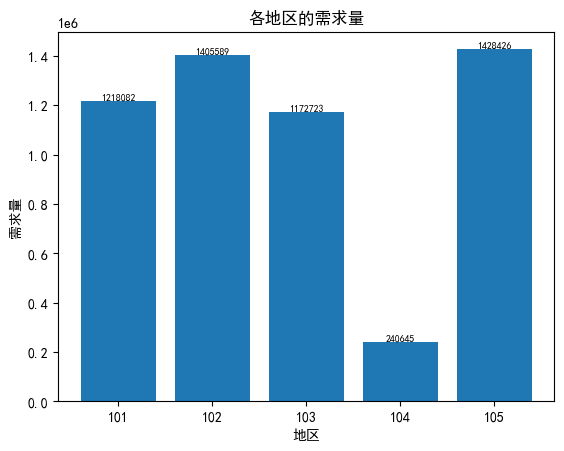

In [69]:
#统计不同地区的总需求量
region_data=data.groupby('sales_region_code').sum('ord_qty')
region_ord_qty=region_data['ord_qty']
# list(region_ord_qty)
region_code=list(region_data.index)
plt.bar(region_code,region_ord_qty)
plt.xlabel('地区')
plt.ylabel('需求量')
plt.title("各地区的需求量")
for x,y in zip(region_code,region_ord_qty):
    plt.text(x,y,'%.0f'%y,ha='center',va='bottom',fontsize=7)
plt.show()


# 不同销售方式（线上和线下）的产品需求量的特性；
这里留个坑：2016年9月抖音上线，统计直播带货爆发后的影响

## 总的需求量

[0, 1]


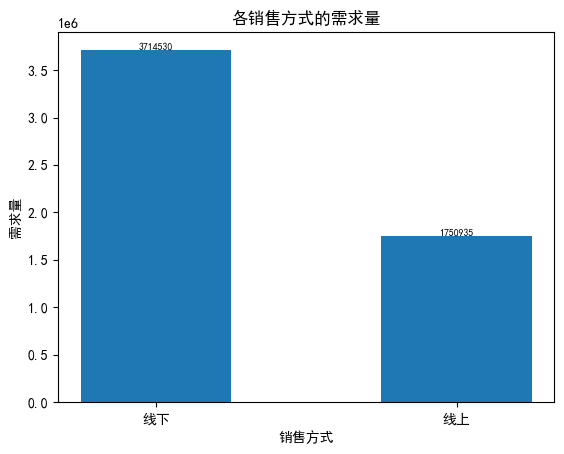

In [87]:
#统计不同销售方式的产品需求量
sales_chan_data=data.groupby('sales_chan').sum('ord_qty')
sales_chan_ord_qty=sales_chan_data['ord_qty']
sales_chan=list(sales_chan_data.index)
print(sales_chan)
plt.bar(['线下','线上'],sales_chan_ord_qty,width=0.5)
plt.xlabel('销售方式')
plt.ylabel('需求量')
plt.title("各销售方式的需求量")
for x,y in zip(sales_chan,sales_chan_ord_qty):
    plt.text(x,y,'%.0f'%y,ha='center',va='bottom',fontsize=7)
plt.show()


## 平均需求量

根据下面的平均需求量可得，每一单线上订单的平均需求量显著大于线下，所以可以适当扩大线上销售途径，增加线上的订单数

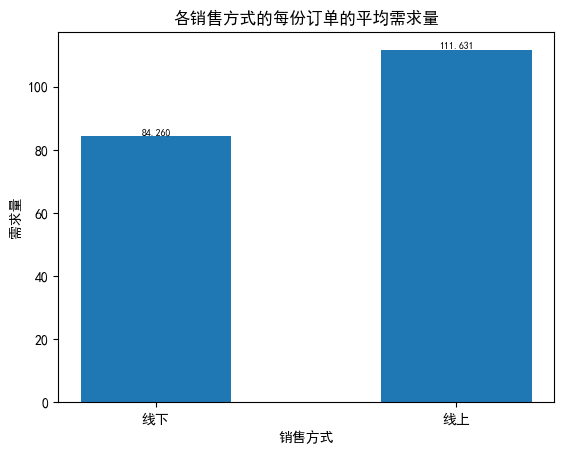

In [101]:
#平均需求量
chan_count=data.groupby('sales_chan').count()['ord_qty']
chan_count=np.array(chan_count)
sales_chan_ord_qty_mean=np.array(sales_chan_ord_qty/chan_count)
plt.bar(['线下','线上'],sales_chan_ord_qty_mean,width=0.5)
plt.xlabel('销售方式')
plt.ylabel('需求量')
plt.title("各销售方式的每份订单的平均需求量")
for x,y in zip(sales_chan,sales_chan_ord_qty_mean):
    plt.text(x,y,'%.3f'%y,ha='center',va='bottom',fontsize=7)
plt.show()

根据平均需求量可得线上的需求量显著大于线下销售渠道的需求量，可从这方面提高销量

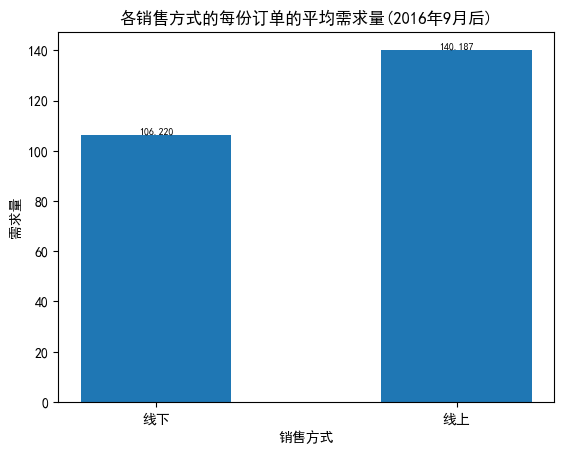

In [168]:
#平均需求量
chan_count=data[data.order_date>'2016-09-01'].groupby('sales_chan').count()['ord_qty']
chan_count=np.array(chan_count)

sales_chan_ord_qty_mean=np.array(sales_chan_ord_qty/chan_count)

plt.bar(['线下','线上'],sales_chan_ord_qty_mean,width=0.5)
plt.xlabel('销售方式')
plt.ylabel('需求量')
plt.title("各销售方式的每份订单的平均需求量(2016年9月后)")
for x,y in zip(sales_chan,sales_chan_ord_qty_mean):
    plt.text(x,y,'%.3f'%y,ha='center',va='bottom',fontsize=7)
plt.show()

 2016年9月抖音平台推出以来，直播带货使线上平均需求量与线下平均需求量的差距进一步增加，根据平均需求量差距的缩小，接下来探索具体到每一个月的线上线下平均销售量的差距

In [153]:
#提取差值和日期
data_YM_sum=data.groupby(['year','month','sales_chan']).sum('ord_qty')["ord_qty"]
data_YM_count=data.groupby(['year','month','sales_chan']).count()['ord_qty']
data_YM_index=data_YM_sum.index
data_YM_sum=pd.DataFrame(data_YM_sum)
data_YM_count=pd.DataFrame(data_YM_count)
data_YM_mean=pd.DataFrame(data_YM_sum/data_YM_count)
# print(data_YM_mean)
# data_YM_sum=np.array(data_YM_sum)
# data_YM_count=np.array(data_YM_count)
# print(data_YM_index,data_YM_sum,data_YM_count)
# print(data_YM_sum/data_YM_count)
data_YM_index=data.groupby(['year','month']).count().index
data_YM_ord=list(data_YM_mean['ord_qty'])
data_YM_chan_diff=[]
for i in range(0,len(data_YM_ord),2):
    data_YM_chan_diff.append(data_YM_ord[i+1]-data_YM_ord[i])
data_YM_index_list=[]
for i in data_YM_index:
    date=""
    date= str(i[0])+'-'+str(i[1])
    data_YM_index_list.append(date)

print(data_YM_chan_diff,data_YM_index_list)


[19.103635132083994, 88.71166892808685, 65.76636451106498, -3.563885379032712, 27.404040404040387, 9.099374499408825, -2.1300374902154573, -7.120785615350826, 44.357556792879706, -40.13754533754533, -6.62984005729291, -4.041929655787314, 40.836997465926984, 44.925454797442654, 23.823206301894828, 0.6083914925342242, 19.78624674249005, 20.986524417802514, -4.552827859148266, 13.452914499132987, 39.569203741277775, -30.31637024989945, 7.452589903336175, 15.067202171593934, 86.10697981771887, 77.89086264116705, 11.181638541971793, -24.43860934701189, 46.56470624473786, 5.232968874700717, 3.174922738813862, 15.562684565673294, 47.94836591578742, -3.1856141307457477, 7.984265297553563, 20.942491120139138, 48.78403429366228, 88.41693785236922, 54.499981987499325, 50.638669695520484] ['2015-9', '2015-10', '2015-11', '2015-12', '2016-1', '2016-2', '2016-3', '2016-4', '2016-5', '2016-6', '2016-7', '2016-8', '2016-9', '2016-10', '2016-11', '2016-12', '2017-1', '2017-2', '2017-3', '2017-4', '2017

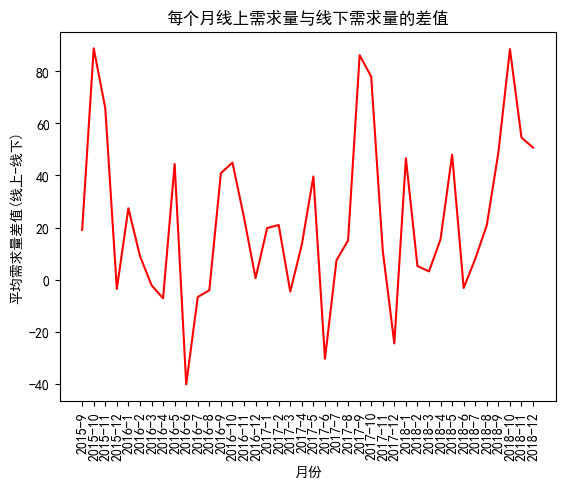

In [167]:
#绘制平均需求量差值折线图
plt.plot(data_YM_index_list,data_YM_chan_diff,color='r')
plt.xlabel('月份')
plt.ylabel('平均需求量差值(线上-线下)')
plt.title('每个月线上需求量与线下需求量的差值')
plt.xticks(rotation=90)
plt.show()

可用于后面季节的分析，秋季线上销售的销售量更多于线下销售量，六月线下会多于线上（why？）

# 不同品类之间的产品需求量有何不同点和共同点；

# 节假日对产品需求量的影响；

# 季节因素对产品需求量的影响。